# Preparations and Data Wrangling

##Load Modules and data

In [1]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from time import sleep
from IPython.display import clear_output
from collections import Counter

In [2]:
#Define wind force class names
wind_force_class_names = ["No wind","Weak wind force","Middle wind force","Strong wind force"]
wind_force_class_names_short = ["No","Weak","Middle","Strong"]

In [3]:
# fun to crop img
def fn_crop_image(img_array, y_start, x_start):
    y_heigth = 60 #ursprünglich 80
    x_width = 110
    
    crop_image = img_array[y_start:y_start+y_heigth,x_start:x_start+x_width] # set RGB to 0 to only analyze red chanel
    return crop_image

# fun to resize img
# to do if further dimension reduction is desired
    

In [4]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")  # mount google drive

Mounted at /content/drive


In [5]:
# define data directory
DATADIR = "/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/Originals/"

# change: import labels
label_df = pd.read_csv("/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/labels_old_camera.csv")

label_df = label_df.rename(columns={"Unnamed: 0": "img"})

# retain only labels / img with meaningful label
label_df = label_df[label_df["wind_force"] != "0"]

# array with img names of labeled img
labeled_img = label_df["img"].to_numpy()

# create numeric wind force variable
label_df["wind_force_num"] = np.where(label_df["wind_force"] == "n", 0,
                             np.where(label_df["wind_force"] == "w", 1,
                             np.where(label_df["wind_force"] == "m", 2,
                             np.where(label_df["wind_force"] == "s", 3, -1))))


## Define Training Data

In [6]:
#Check label counts
label_df["wind_force_num"].value_counts()

1    162
2     68
0     31
3      7
Name: wind_force_num, dtype: int64

In [7]:
#Create Training Data
training_data = []

#Set True to harmonize amount of pictures per label (multiply pictures and labels for categories)
harmonize = True
# Get count per label value and calculate factors for harmonizing amounts
label_value_counts = label_df["wind_force_num"].value_counts()

maxLabels = label_value_counts.max()
factor0 = round(maxLabels / label_value_counts.loc[0])
factor1 = round(maxLabels / label_value_counts.loc[1])
factor2 = round(maxLabels / label_value_counts.loc[2])
factor3 = round(maxLabels / label_value_counts.loc[3])
if harmonize:
  print(f"factors for 0,1,2,3 category: {factor0,factor1,factor2,factor3}")


def create_training_data():
    for img in labeled_img:
        path = os.path.join(DATADIR, img)
        img_array = cv2.imread(os.path.join(path))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
        new_array = fn_crop_image(img_array, 250, 570)
        wind_label = label_df.loc[label_df["img"] == img, "wind_force_num"] # get label to coresponding img
        wind_label = np.ndarray.item(wind_label.to_numpy()) # convert to single scalar integer
        if harmonize:
          if wind_label == 0: #No wind
            for i in range(factor0):
              training_data.append([new_array, wind_label])
          if wind_label == 1: #Middle wind
            for i in range(factor1):
              training_data.append([new_array, wind_label])
          if wind_label == 2: #Middle wind
            for i in range(factor2):
              training_data.append([new_array, wind_label])
          if wind_label == 3: #Strong wind
            for i in range(factor3):
              training_data.append([new_array, wind_label])
        else:
          training_data.append([new_array, wind_label])
    
create_training_data()


# Create lists for images and labels
images = []
labels = []

for feature, label in training_data:
    images.append(feature)
    labels.append(label)

# reshape images and mutate to np.array
np_images = np.array(images).reshape(-1, np.array(images).shape[1], np.array(images).shape[2], np.array(images).shape[3])
np_labels = np.array(labels)

#Check counts of labels
Counter(np_labels)

factors for 0,1,2,3 category: (5, 1, 2, 23)


Counter({1: 162, 0: 155, 2: 136, 3: 161})

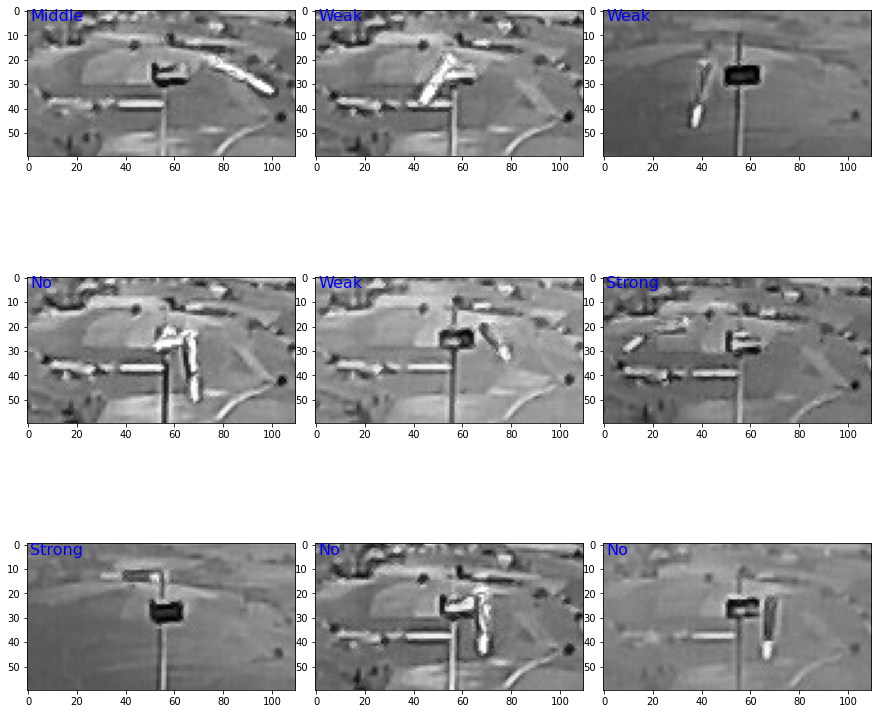

In [9]:
#Check examples:
n = 3
fig, ax = plt.subplots(n, n, figsize=(4*n, 4*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
np.random.seed(7)
for axi, im_idx in zip(ax, np.random.choice(len(np_images), n**2)):
  im = np_images[im_idx]
  im_class = wind_force_class_names_short[np_labels[im_idx]]
  axi.imshow(im[:,:,0], cmap='gray')
  axi.text(1, 4, f'{im_class}', color='b', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

## Other

In [10]:
#Understand training_data
#training_data[0] --> List (Image pixels plus label for the first image)
#training_data[0][0] --> numpy.ndarray for image pixels for first image.
#traninng_data[0][0].shape --> (80, 110, 3) (Shape of first image --> compare fn_crop_image)
#training_data[0][1] --> int für Windstärke Label

print(f"type :{training_data[0][0].shape}")
print(f"Number of pictures: {len(training_data)}")

type :(60, 110, 3)
Number of pictures: 614


D20220926_185628_6291.jpg


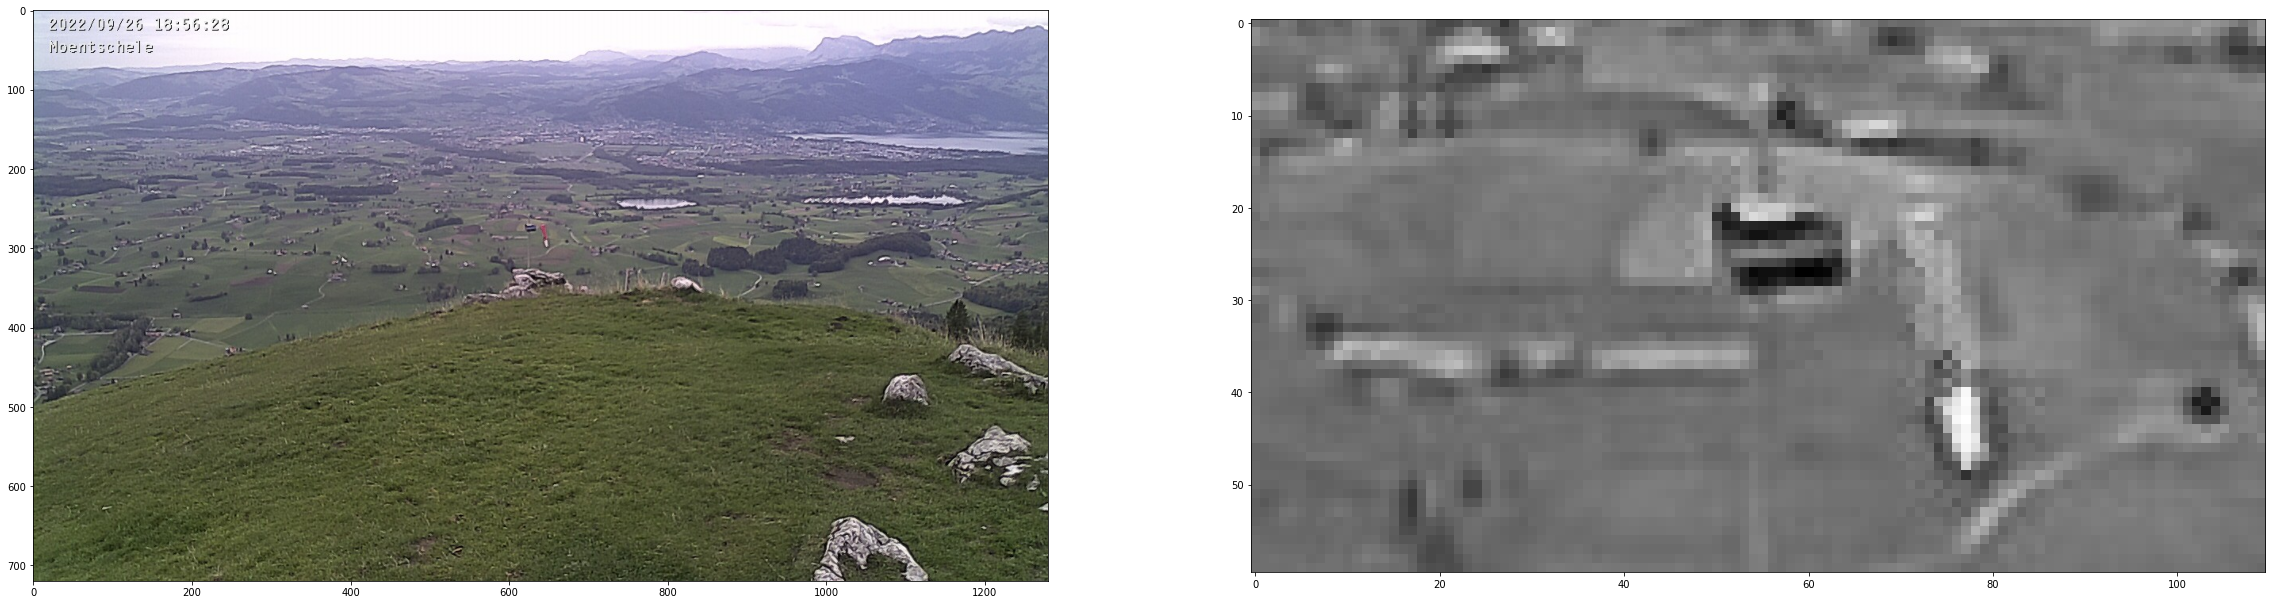

hit enter to continue or exit
exit


In [11]:
#Show images in labeled_img:
sleep_seconds = 1
for image_name in labeled_img:
  fig = plt.figure(1,figsize= (40,15))
  chart0 = fig.add_subplot(121)
  chart1 = fig.add_subplot(122)
  img_array = cv2.imread(os.path.join(DATADIR+image_name))
  img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
  #ursprünglich: new_array = fn_crop_image(img_array,230,570)
  new_array = fn_crop_image(img_array,250,570)
  new_array = new_array[:,:,0]
  print(image_name)
  chart0.imshow(img_array)
  chart1.imshow(new_array, cmap = 'gray')
  plt.show()
  sleep(sleep_seconds)
  print("hit enter to continue or exit")
  answer = input()
  if answer == "exit":
    break
  clear_output()

# Try ML models

##Preparations

### Load modules

In [13]:
# Scikit-learn (formerly scikits.learn and also known as sklearn) is a free 
# software machine learning library for the Python programming language. 
# It features various classification, regression and clustering algorithms, 
# and is designed to interoperate with the Python numerical and scientific 
# libraries NumPy and SciPy. (from wiki)

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

### Convert Image Shape and split to train and test set

In [14]:
#Convert image shape and split to train and test set
label_amount = np_labels.size

print(f"np_images shape: {np_images.shape}")
np_images_red = np_images[:,:,:,0] #reduce to red channel
print(f"np_images_red shape: {np_images_red.shape}")

np_images_red_flatten = np_images_red[:label_amount,:].reshape(label_amount,-1)
print(f"np_images_red_flatten shape: {np_images_red_flatten.shape}")

#1) Split into train and test set:
x_train, x_test, y_train, y_test = train_test_split(np_images_red_flatten, np_labels, test_size=0.2,random_state=7)

print(f"np_labels shape: {np_labels.shape}")

np_images shape: (614, 60, 110, 3)
np_images_red shape: (614, 60, 110)
np_images_red_flatten shape: (614, 6600)
np_labels shape: (614,)


##Linear Model - Linear Regression (exploration only)

---



In [15]:
# 2. fit the model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [16]:
# 3. evaluate MSE, MAD, and R2 on train and test datasets
# Mean square error
print(f"MSE train data: {np.std(y_train - reg.predict(x_train))}")
print(f"MSE test data: {np.std(y_test - reg.predict(x_test))}")
# Mean absolute error
print(np.mean(np.abs(y_test - reg.predict(x_test))))
from sklearn.metrics import mean_absolute_error
print(f"MAE train data: {mean_absolute_error(y_train,reg.predict(x_train))}")
print(f"MAE test data: {mean_absolute_error(y_test,reg.predict(x_test))}")
# R2

MSE train data: 5.01783642182629e-15
MSE test data: 0.1382414376266832
0.06064148323855001
MAE train data: 3.960398426946969e-15
MAE test data: 0.06064148323855001


In [17]:
y_test_pred = reg.predict(x_test)

In [18]:
wrong_pred = []
for i in range(y_test.size):
  if y_test[i] != round(y_test_pred[i]):
    wrong_pred.append(i)
print(f"Wrong predictions: {len(wrong_pred)}, right predictions: {y_test_pred.size-len(wrong_pred)}, Test accuracy: {1-len(wrong_pred)/y_test_pred.size}")

Wrong predictions: 1, right predictions: 122, Test accuracy: 0.991869918699187


## Linear Model - Logistic Regression

### Train and Validate the model

In [21]:
#1 Create classifier
iterations = 2500 #define number of iterations (also used for exporting filename)

multi_class='multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=iterations, multi_class='multinomial', )
# fit the model
clf.fit(x_train, y_train)
#print(x_train.shape) --> 

#Evaluate accuracy on train and test datasets
print("training accuracy : %.3f (%s)" % (clf.score(x_train, y_train), multi_class))
print("Test accuracy : %.3f (%s)" % (clf.score(x_test, y_test), multi_class))

y_test_pred = clf.predict(x_test)
y_train_pred = clf.predict(x_train)

training accuracy : 1.000 (multinomial)
Test accuracy : 0.992 (multinomial)


### Check classifier performance

In [22]:
# Print number of wrong predictions and corresponding indices
wrong_pred = []
for i in range(y_test.size):
  if y_test[i] != y_test_pred[i]:
    wrong_pred.append(i)
print(f"Number of wrong predictions: {len(wrong_pred)}")
wrong_pred


Number of wrong predictions: 1


[8]

Label: Weak wind force
Prediction: Middle wind force
Sorry, not correct!


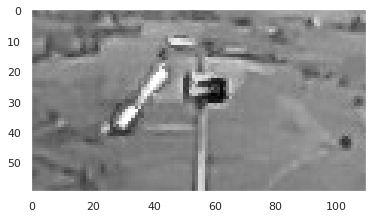

In [23]:
# Check wrong prediction
idx = 8
plt.grid(False)
plt.imshow(x_test[idx].reshape(60,110),cmap='gray')
c_true = y_test[idx]
c_pred = y_test_pred[idx]
print('Label:', wind_force_class_names[c_true])
print('Prediction:', wind_force_class_names[c_pred])
#To do: can we somehow find out the original filename. Would be nice to correct wrong labels..
if c_true == c_pred:
  print('Hurray! :-)')
else:
  print('Sorry, not correct!')

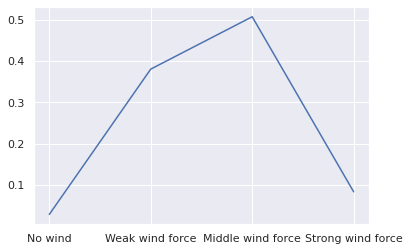

In [26]:
# Plot probabilities for index
idx = 8
y_test_pred_p = clf.predict_proba(x_test)
plt.plot(wind_force_class_names, y_test_pred_p[idx])

In [27]:
# Prepare for confusion matrix
cm_train = metrics.confusion_matrix(y_train, y_train_pred)
score_train = clf.score(x_train, y_train)
cm_test = metrics.confusion_matrix(y_test, y_test_pred)
score_test = clf.score(x_test, y_test)


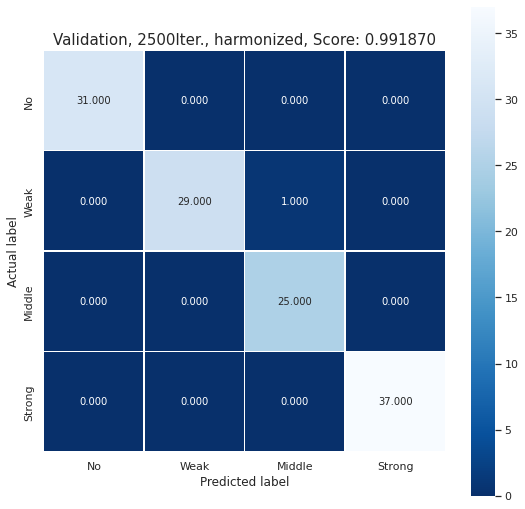

In [29]:
# Plot confusion matrix
cm = cm_test
score = score_test
data_type = "Validation"
if harmonize:
  harm = 'harmonized'
else:
  harm = 'not harm.'
plt.figure(figsize=(9,9))
sns.heatmap(cm, xticklabels = wind_force_class_names_short, yticklabels = wind_force_class_names_short, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = data_type + ', ' + str(iterations) + 'Iter., ' + harm + ', ' + 'Score: {:2f}'.format(score)
plt.title(all_sample_title, size = 15);

## Safe the model
https://scikit-learn.org/stable/model_persistence.html

In [ ]:
# Safe linear regression model to disk with joblib
from joblib import dump, load
dumpDir = "/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/"
if harmonize:
  reg_filename = "model_lin_reg_harm.joblib"
else:
  reg_filename = "model_lin_reg_noHarm.joblib"
dump(reg, dumpDir+reg_filename) 

['/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/model_lin_reg_noHarm.joblib']

In [ ]:
# Safe logistic regression model to disk with joblib
from joblib import dump, load
dumpDir = "/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/"
if harmonize:
  clf_filename = "model_clf_log_reg_harm_" + str(iterations) + ".joblib"
else:
  clf_filename = "model_clf_log_reg_noHarm_" + str(iterations) + ".joblib"
dump(clf, dumpDir+clf_filename) 

['/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/model_clf_log_reg_harm_2500_AllChannels.joblib']